In [1]:
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.cif import CifParser
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.io.xyz import XYZ
from pymatgen.io.gaussian import GaussianInput
import numpy as np
import os
from matplotlib import pyplot as plt


species_index_dict = {
    'C': 1,
    'Li': 2
}

species_labels_dict = {
    'C': f"{species_index_dict['C']} 6  C-gga",
    'Li': f"{species_index_dict['Li']} 3  Li-gga"
}

In [2]:
strains = np.arange(-0.5, 0.5, 0.01)

In [3]:
structures = {}
for strain in strains:
    graphite = Structure.from_file('graphite.3x3x1.cif')
    graphite.apply_strain([0, 0, strain])
    structures[strain] = graphite

In [22]:
structures[strains[50]].lattice

Lattice
    abc : 7.392 7.392 6.711000000000003
 angles : 90.0 90.0 119.99999999999999
 volume : 317.5716949250791
      A : 7.392 0.0 4.526294569648617e-16
      B : -3.695999999999998 6.401659784774572 4.526294569648617e-16
      C : 0.0 0.0 6.711000000000003

## Write inputs for SZ with grimm correction

In [ ]:
for strain in strains:
    file=f"./graphite_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.siesta_template_tail.txt >> {file}")

## Write inputs for SZ with 4x4x4 scan

In [12]:
for strain in strains:
    file=f"./graphite_4x4x4_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.4x4x4.siesta_template_tail.txt >> {file}")

### Plot results

lowest energy = -5541.851008
Bottom of well = [5.301690000000002]


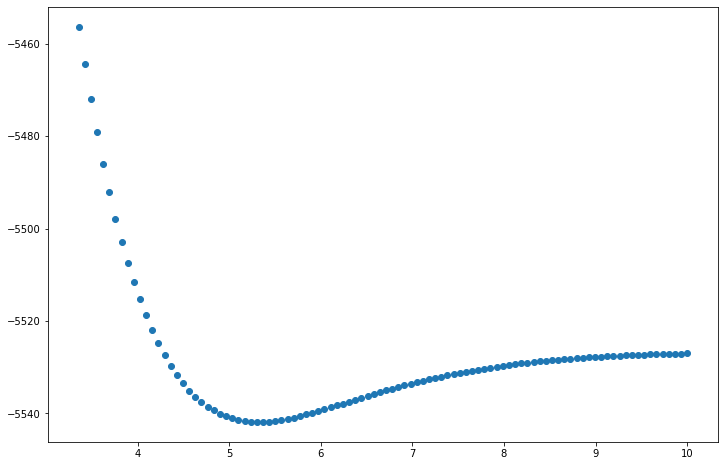

In [25]:
energies = []
for strain in strains:
    with open(f"./graphite_4x4x4_scan/outputs/OUT.graphite.{round(strain,2)}_zStrain") as f:
        for line in f:
            if "siesta:         Total =" in line:
                energies.append(float(line.strip().split()[3]))

z_distance = [6.711 * (1+s) for s in strains]

print(f"lowest energy = {np.min(energies)}")
mindist = [z_distance[i] for i,j in enumerate(energies) if j == np.min(energies)]
print(f"Bottom of well = {mindist}")

plt.figure(figsize=(12,8))
plt.scatter(z_distance,energies)
plt.show()

In [30]:
z_distance[29]

5.301690000000002

In [32]:
structures[strains[29]].lattice

Lattice
    abc : 7.392 7.392 5.301690000000002
 angles : 90.0 90.0 119.99999999999999
 volume : 250.88163899081246
      A : 7.392 0.0 4.526294569648617e-16
      B : -3.695999999999998 6.401659784774572 4.526294569648617e-16
      C : 0.0 0.0 5.301690000000002

#### Calculate elastic constant



$ \frac {\Delta E} {V} = \frac {1} {2} C_{33} \delta ^2 $

Where V is the volume of the undistorted lattice, $ \Delta E $ is the change in energy and $ \delta $ is the applied strain from the strain tensor $ e=(0,0,0,\delta,0,0) $ 


Units:

$ V: Ang^3 $

$ \Delta E: eV $

$ 1 eV/Ang^3 = 160.21766208 $ GPa

Undistorted lattice assumed to be the system with lowest energy, which for this scan was calculated to be at $ a=7.392, c=5.302 $

$ V =  250.882 $




In [46]:
# bottom of well occurs at strains[29] or -21% deformation
dE1 = energies[29] - energies[28]
dE11 = energies[29] - energies[30]

d = 0.06711
V = 250.882

pos_C33 = 2*(dE1 / V) / d**2
neg_C33 = 2*(dE11 / V) / d**2
print(pos_C33)
print(neg_C33)

-0.10579777559701839
-0.034138992119466326


In [115]:
z_distance[50]

6.711000000000003

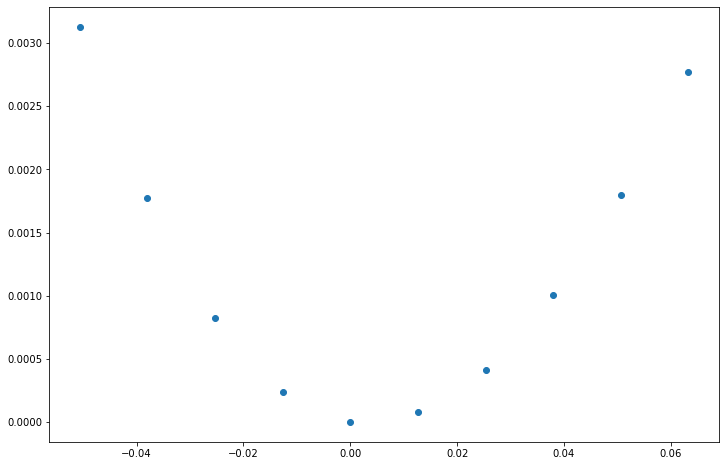

In [89]:
dEV = [(e - energies[29])/250.882 for e in energies]
delta = [-(z_distance[29] - d) / z_distance[29] for d in z_distance]

plt.figure(figsize=(12,8))
# plt.scatter(delta[20:40],dEV[20:40])
plt.scatter(delta[25:35],dEV[25:35])
plt.show()

In [85]:
C33s = []
for i in np.arange(0,len(delta)):
    if delta[i] != 0.0:
        C33 = 2*(dEV[i]/V)/delta[i]**2
    else:
        C33 = 0.0
    
    C33s.append(C33)

### Fit quadratic

Elastic constant (C33) comes from the quadratic term of the polynomial fit

In [109]:
fit = np.polyfit(delta[25:35],dEV[25:35],deg=2)

In [110]:
fit

array([ 9.08633283e-01, -1.22454856e-02,  4.19241160e-05])

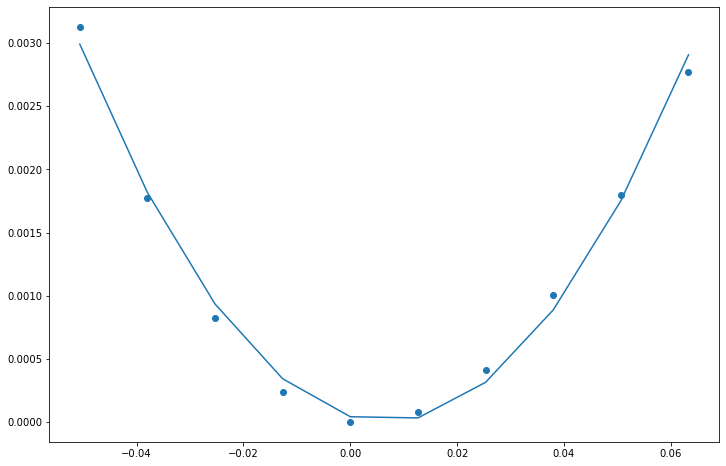

In [112]:
points = [fit[2] + fit[1]*i + fit[0]*i**2 for i in delta[25:35]]

dEV = [(e - energies[29])/250.882 for e in energies]
delta = [-(z_distance[29] - d) / z_distance[29] for d in z_distance]

plt.figure(figsize=(12,8))
# plt.scatter(delta[20:40],dEV[20:40])
plt.scatter(delta[25:35],dEV[25:35])
plt.plot(delta[25:35],points)
plt.show()

In [ ]:
C33s[25:]

In [70]:
test = [d**2 for d in delta]

In [58]:
np.arange(0,len(delta))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [39]:
z_distance[29] - z_distance[28]

0.06710999999999956

#### WTF

## Repeat for 4x4x4 grid with DZP

In [19]:
for strain in strains:
    file=f"./graphite_dzp_scan/graphite.{round(strain,2)}_zStrain.fdf"
    
    os.system(f"cat graphite.DZP.siesta_template_head.txt > {file}")

    with open(file, "a") as f:
        f.write('\n\nLatticeConstant 1.000000 Ang\n')
        f.write('%block LatticeVectors\n')
        for i in structures[strain].lattice.as_dict()['matrix']:
            f.write(f"\t{i[0]:.10f}\t{i[1]:.10f}\t{i[2]:.10f}\n")
        f.write('%endblock LatticeVectors\n\n')
        f.write('AtomicCoordinatesFormat Ang\n')
        f.write('%block AtomicCoordinatesAndAtomicSpecies\n')
        for i in structures[strain].sites:
            coord = i.coords
            f.write(f"\t{coord[0]:.8f}\t{coord[1]:.8f}\t{coord[2]:.8f}\t{species_index_dict[i.species_string]}\n")
        f.write('%endblock AtomicCoordinatesAndAtomicSpecies\n\n')

    os.system(f"cat graphite.4x4x4.siesta_template_tail.txt >> {file}")

lowest energy = -5581.93926
Bottom of well = [6.375450000000003]


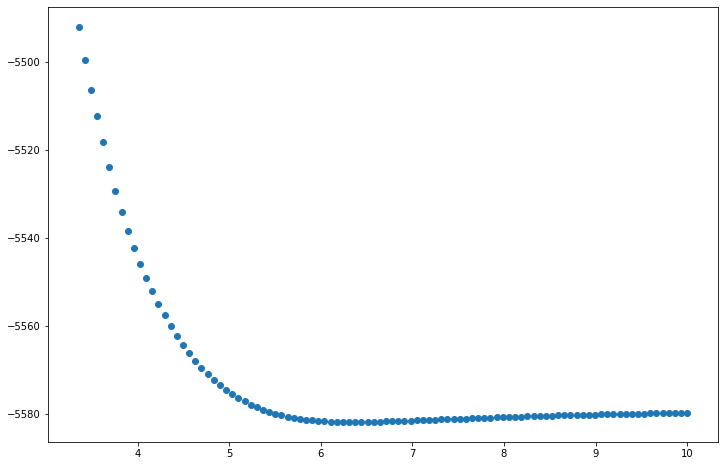

In [125]:
energies = []
for strain in strains:
    with open(f"./graphite_dzp_scan/outputs/OUT.graphite.{round(strain,2)}_zStrain") as f:
        for line in f:
            if "siesta:         Total =" in line:
                energies.append(float(line.strip().split()[3]))

z_distance = [6.711 * (1+s) for s in strains]

print(f"lowest energy = {np.min(energies)}")
mindist = [z_distance[i] for i,j in enumerate(energies) if j == np.min(energies)]
print(f"Bottom of well = {mindist}")

plt.figure(figsize=(12,8))
plt.scatter(z_distance,energies)
plt.show()

In [123]:
z_distance[45]

6.375450000000003

C33 = 33.701025072005656 GPa


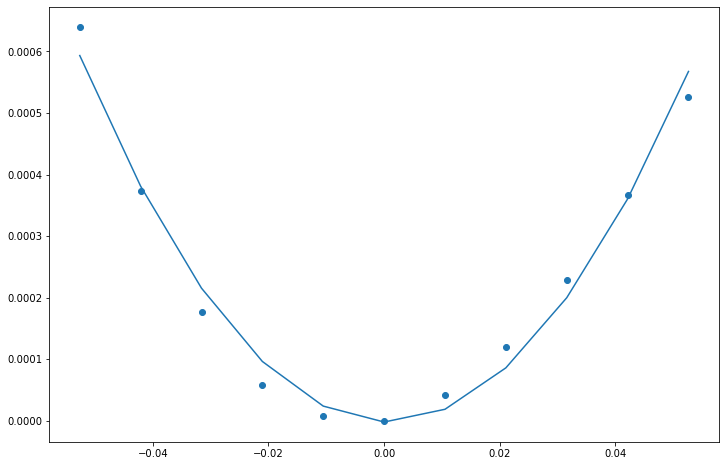

In [132]:
dEV = [(e - energies[45])/250.882 for e in energies]
delta = [-(z_distance[45] - d) / z_distance[45] for d in z_distance]

fit = np.polyfit(delta[40:51],dEV[40:51],deg=2)
print(f"C33 = {fit[0]*160.22} GPa")

points = [fit[2] + fit[1]*i + fit[0]*i**2 for i in delta[40:51]]


plt.figure(figsize=(12,8))
plt.scatter(delta[40:51],dEV[40:51])
plt.plot(delta[40:51],points)
#plt.scatter(delta[35:55],dEV[35:55])
plt.show()